In [9]:
import pandas as pd
import numpy as np

df = pd.read_csv('all_data.csv')
df = df.dropna(subset=['pm25'])
df

,Unnamed: 0.1,Unnamed: 0,date,stacja,pm25,temperature_2m_min,wind_speed_10m_max,wind_direction_10m_dominant,cloud_cover_mean,surface_pressure_mean,...,boundary_layer_height,lat,lon,nearest_road_dist_m,total_road_length_km,building_count,elevation,population,built_up_surface,built_up_volume
0,0,0,2016-01-01 00:00:00+00:00,DsLegAlRzecz,59.30,-1.932500,11.753877,289.29013,100.000000,1010.14970,...,191.66667,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
1,1,1,2016-01-02 00:00:00+00:00,DsLegAlRzecz,54.70,-9.532500,22.896110,102.65439,59.958332,1009.82965,...,433.12500,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
2,2,2,2016-01-03 00:00:00+00:00,DsLegAlRzecz,69.00,-12.282500,18.709612,107.50388,49.416668,1003.64520,...,398.33334,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
3,3,3,2016-01-04 00:00:00+00:00,DsLegAlRzecz,80.10,-10.632501,20.696087,118.76107,92.458336,985.55080,...,477.91666,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
4,4,4,2016-01-05 00:00:00+00:00,DsLegAlRzecz,100.50,-7.082500,13.324863,86.64323,95.750000,985.00410,...,268.75000,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66912,66912,66912,2018-12-28 00:00:00+00:00,ZpSzczec1Maj,4.90,4.139000,24.535526,298.53427,100.000000,1003.10750,...,728.54170,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0
66913,66913,66913,2018-12-29 00:00:00+00:00,ZpSzczec1Maj,8.16,3.889000,17.555307,256.10280,99.958336,1004.09380,...,552.08330,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0
66914,66914,66914,2018-12-30 00:00:00+00:00,ZpSzczec1Maj,4.35,1.689000,27.002400,298.98737,95.958336,1000.37670,...,665.83330,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0
66915,66915,66915,2018-12-31 00:00:00+00:00,ZpSzczec1Maj,7.44,1.839000,20.883102,271.19727,98.791664,1009.56620,...,395.62500,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0


In [10]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

# Konwersja dat i dodanie cech czasowych
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df = df.sort_values(['stacja', 'date'])
'''
# Lista cech
features = [
    'temperature_2m_min', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
    'cloud_cover_mean', 'surface_pressure_mean', 'dew_point_2m_mean',
    'boundary_layer_height', 'nearest_road_dist_m', 'total_road_length_km',
    'building_count', 'elevation', 'population', 'built_up_surface',
    'built_up_volume', 'year', 'month', 'day', 'weekday'
]
'''
# Lista cech
features = [
    'temperature_2m_min', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
    'surface_pressure_mean', 'dew_point_2m_mean',
    'nearest_road_dist_m', 'total_road_length_km',
    'elevation',
]
target = 'pm25'

# Skalery
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Funkcja tworząca sekwencje
def create_sequences(data, feature_cols, target_col, lookback=30, forecast_horizon=5):
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        seq_x = data[feature_cols].iloc[i:i+lookback].values
        seq_y = data[target_col].iloc[i+lookback:i+lookback+forecast_horizon].values
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Tworzenie sekwencji dla każdej stacji
X_list, y_list = [], []
for stacja, group in df.groupby('stacja'):
    group = group.sort_values('date').reset_index(drop=True)

    # Skalowanie
    scaled_features = scaler_X.fit_transform(group[features])
    scaled_target = scaler_y.fit_transform(group[[target]])

    scaled_df = pd.DataFrame(scaled_features, columns=features)
    scaled_df[target] = scaled_target

    X_seq, y_seq = create_sequences(scaled_df, features, target, lookback=30, forecast_horizon=5)
    X_list.append(X_seq)
    y_list.append(y_seq)

# Sklejenie wszystkiego w jedną macierz
X_all = np.vstack(X_list)
y_all = np.vstack(y_list)  # UWAGA: wcześniej było hstack → błąd

# Podział na train/test
split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

# Model LSTM
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(5))  # 5 dni prognozy
model.compile(optimizer='adam', loss='mse')

# Trening
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Ewaluacja
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Predykcje i odwrócenie skalowania
y_pred = model.predict(X_test)

# Odwrócenie skalowania dla każdego dnia osobno
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)


Epoch 1/20


c:\Users\szymo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1395/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.5206 - val_loss: 0.4543
Epoch 2/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.4138 - val_loss: 0.4164
Epoch 3/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.3707 - val_loss: 0.3675
Epoch 4/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.3439 - val_loss: 0.3750
Epoch 5/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.3214 - val_loss: 0.3484
Epoch 6/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.3060 - val_loss: 0.3562
Epoch 7/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.2931 - val_loss: 0.3822
Epoch 8/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.2815 - val_loss: 0.3574
Epoch 9/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.2728 - val_loss: 0.3383
Epoch 10/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.2632 - val_loss: 0.3372
Epoch 11/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.2542 - val_loss: 0.3226
Epoch 12/20
1395/13

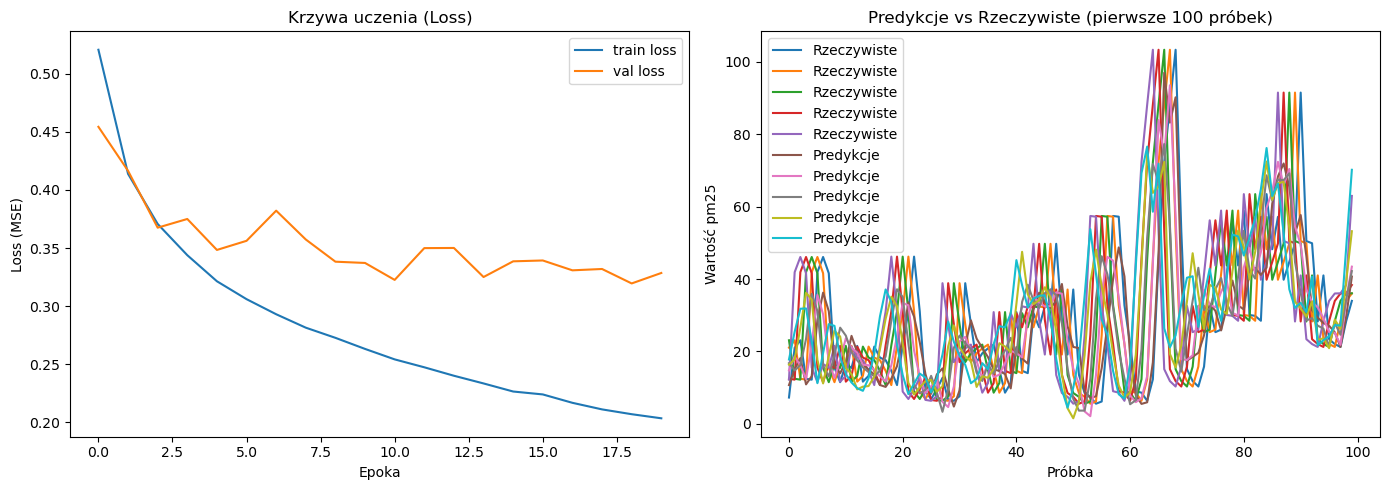

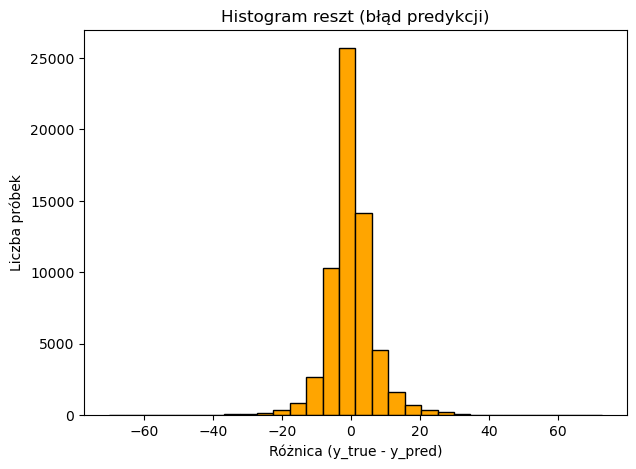

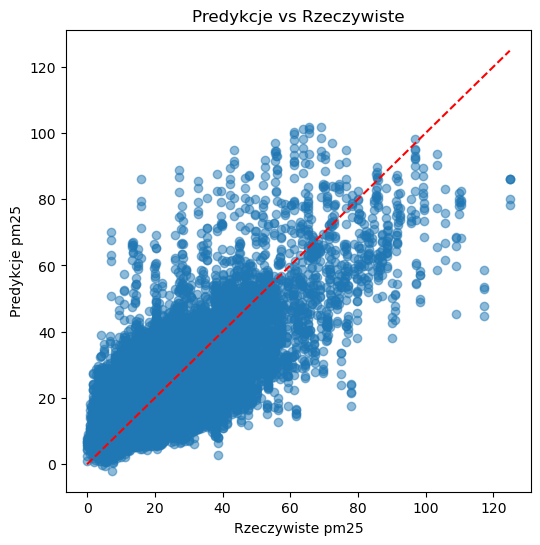

MAE: 4.589
RMSE: 6.925
R^2: 0.660


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_lstm_diagnostics(history, y_test_rescaled, y_pred_rescaled):
    """
    Rysuje wykresy diagnostyczne po trenowaniu LSTM.

    Args:
        history: Obiekt zwrócony przez model.fit() (historia treningu).
        y_test_rescaled: Prawdziwe wartości (odwrócone skalowanie), np. pm25.
        y_pred_rescaled: Predykcje modelu (odwrócone skalowanie).
    """

    # 1. Krzywa uczenia
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history.get('val_loss', []), label='val loss')
    plt.title('Krzywa uczenia (Loss)')
    plt.xlabel('Epoka')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # 2. Porównanie predykcji i prawdziwych wartości (np. pierwsze 100 próbek)
    plt.subplot(1,2,2)
    plt.plot(y_test_rescaled[:100], label='Rzeczywiste')
    plt.plot(y_pred_rescaled[:100], label='Predykcje')
    plt.title('Predykcje vs Rzeczywiste (pierwsze 100 próbek)')
    plt.xlabel('Próbka')
    plt.ylabel('Wartość pm25')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Histogram reszt
    residuals = y_test_rescaled.flatten() - y_pred_rescaled.flatten()
    plt.figure(figsize=(7,5))
    plt.hist(residuals, bins=30, color='orange', edgecolor='k')
    plt.title('Histogram reszt (błąd predykcji)')
    plt.xlabel('Różnica (y_true - y_pred)')
    plt.ylabel('Liczba próbek')
    plt.show()

    # 4. Scatter plot: predykcje vs rzeczywiste
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.5)
    plt.plot([y_test_rescaled.min(), y_test_rescaled.max()],
             [y_test_rescaled.min(), y_test_rescaled.max()], 'r--')  # linia y=x
    plt.title('Predykcje vs Rzeczywiste')
    plt.xlabel('Rzeczywiste pm25')
    plt.ylabel('Predykcje pm25')
    plt.show()

    # 5. Metryki
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    print(f'MAE: {mae:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'R^2: {r2:.3f}')

plot_lstm_diagnostics(history, y_test_rescaled, y_pred_rescaled)

In [12]:
model.save('moj_model_lstm_malozmiennych_5dni.h5')  # zapis do pliku .h5

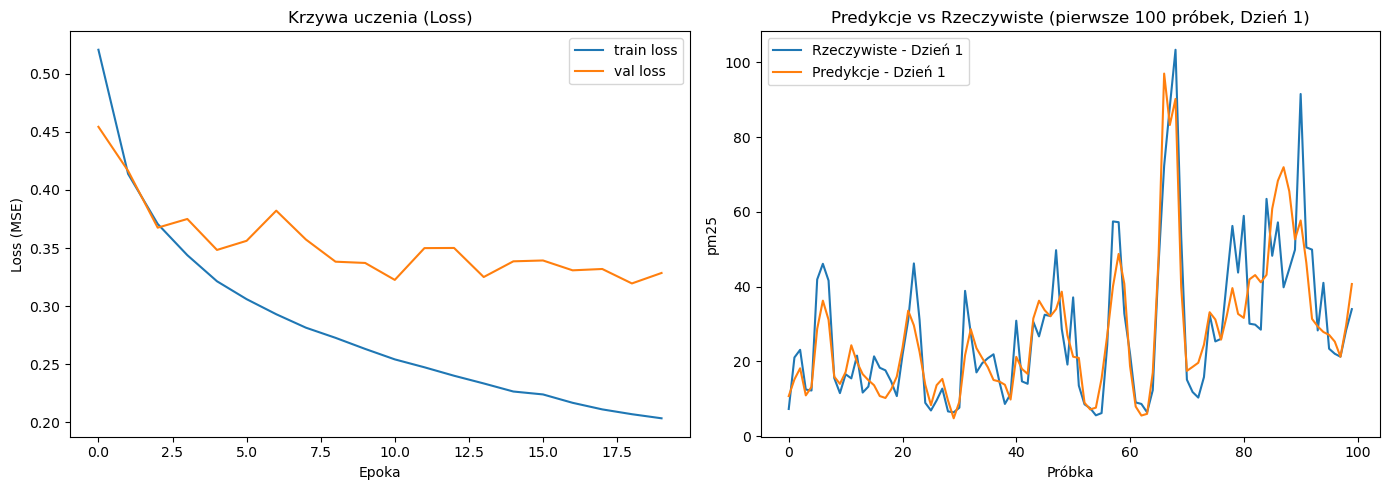

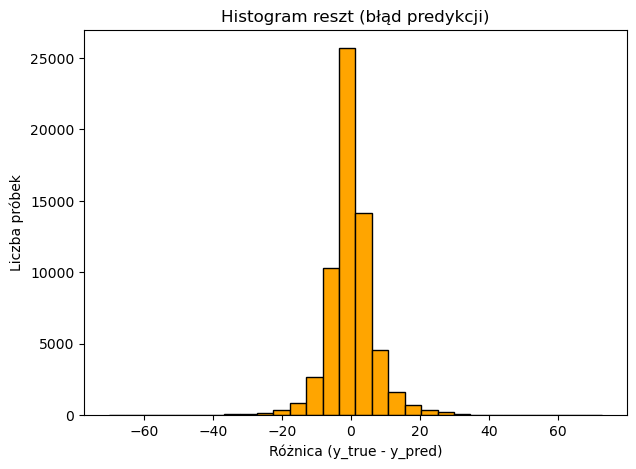

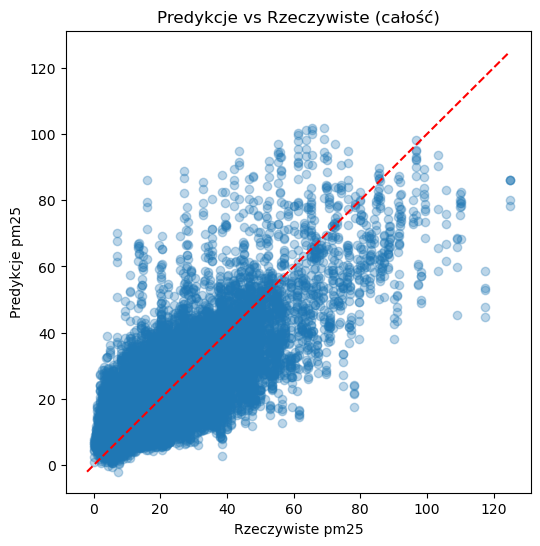

=== METRYKI GLOBALNE ===
MAE: 4.589
RMSE: 6.925
R²: 0.660
Bias: 0.065

=== METRYKI PER DZIEŃ ===

Dzień 1:
  MSE: 44.692
  RMSE: 6.685
  Bias: -0.344
  R²: 0.684
  Korelacja: 0.830


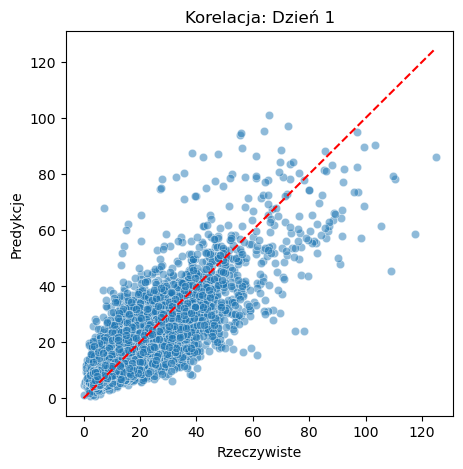


Dzień 2:
  MSE: 47.293
  RMSE: 6.877
  Bias: -0.190
  R²: 0.666
  Korelacja: 0.820


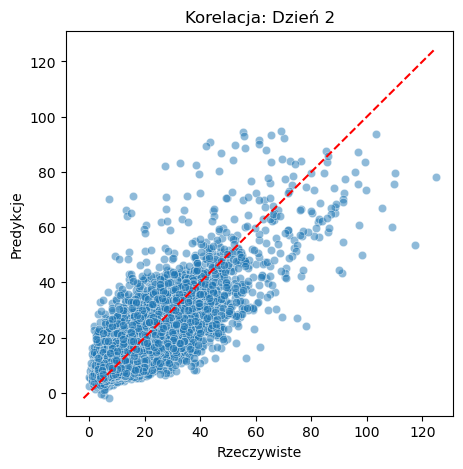


Dzień 3:
  MSE: 49.065
  RMSE: 7.005
  Bias: 0.366
  R²: 0.653
  Korelacja: 0.813


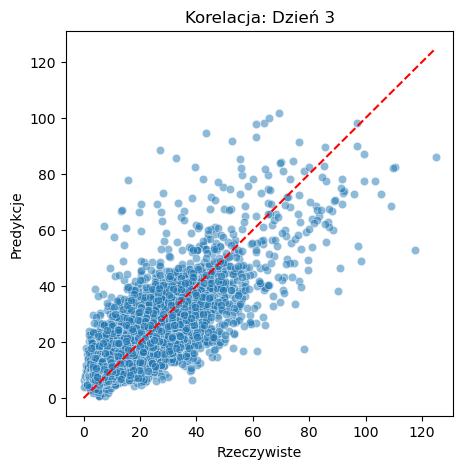


Dzień 4:
  MSE: 48.823
  RMSE: 6.987
  Bias: 0.197
  R²: 0.654
  Korelacja: 0.812


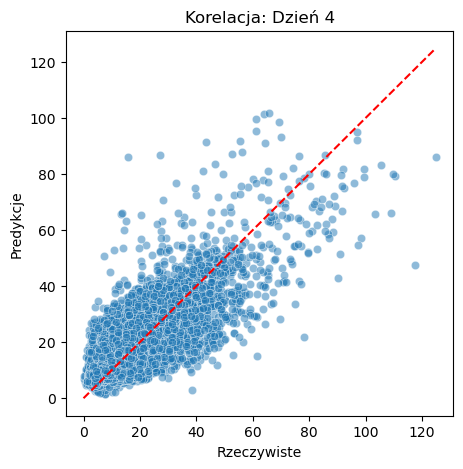


Dzień 5:
  MSE: 49.989
  RMSE: 7.070
  Bias: 0.294
  R²: 0.646
  Korelacja: 0.808


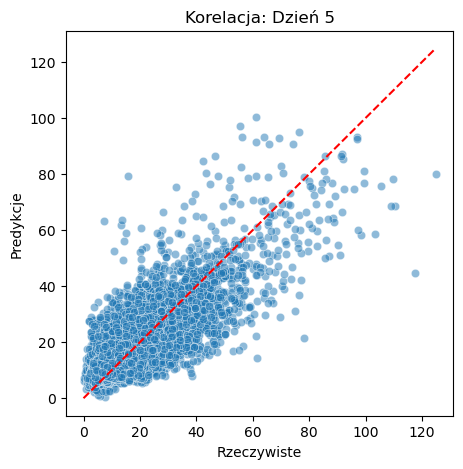

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_lstm_diagnostics_multistep(history, y_test_rescaled, y_pred_rescaled):
    """
    Rysuje diagnostykę po trenowaniu LSTM (multi-step forecast).
    
    Args:
        history: historia z model.fit()
        y_test_rescaled: macierz (n_samples, forecast_horizon)
        y_pred_rescaled: macierz (n_samples, forecast_horizon)
    """

    forecast_horizon = y_test_rescaled.shape[1]

    # 1. Krzywa uczenia
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Krzywa uczenia (Loss)')
    plt.xlabel('Epoka')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # 2. Porównanie predykcji i prawdziwych wartości dla 1. dnia
    plt.subplot(1,2,2)
    plt.plot(y_test_rescaled[:100, 0], label='Rzeczywiste - Dzień 1')
    plt.plot(y_pred_rescaled[:100, 0], label='Predykcje - Dzień 1')
    plt.title('Predykcje vs Rzeczywiste (pierwsze 100 próbek, Dzień 1)')
    plt.xlabel('Próbka')
    plt.ylabel('pm25')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Histogram reszt dla całej prognozy
    residuals = (y_test_rescaled - y_pred_rescaled).flatten()
    plt.figure(figsize=(7,5))
    plt.hist(residuals, bins=30, color='orange', edgecolor='k')
    plt.title('Histogram reszt (błąd predykcji)')
    plt.xlabel('Różnica (y_true - y_pred)')
    plt.ylabel('Liczba próbek')
    plt.show()

    # 4. Scatter plot: predykcje vs rzeczywiste dla całej prognozy
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_rescaled.flatten(), y_pred_rescaled.flatten(), alpha=0.3)
    lims = [
        min(y_test_rescaled.min(), y_pred_rescaled.min()),
        max(y_test_rescaled.max(), y_pred_rescaled.max())
    ]
    plt.plot(lims, lims, 'r--')
    plt.title('Predykcje vs Rzeczywiste (całość)')
    plt.xlabel('Rzeczywiste pm25')
    plt.ylabel('Predykcje pm25')
    plt.show()

    # 5. Metryki globalne
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    bias = np.mean(y_pred_rescaled - y_test_rescaled)

    print("=== METRYKI GLOBALNE ===")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")
    print(f"Bias: {bias:.3f}")

    # 6. Metryki i korelacje dla każdego dnia do przodu
    print("\n=== METRYKI PER DZIEŃ ===")
    for day in range(forecast_horizon):
        y_true_d = y_test_rescaled[:, day]
        y_pred_d = y_pred_rescaled[:, day]
        
        mse_d = mean_squared_error(y_true_d, y_pred_d)
        rmse_d = np.sqrt(mse_d)
        bias_d = np.mean(y_pred_d - y_true_d)
        r2_d = r2_score(y_true_d, y_pred_d)
        corr_d = np.corrcoef(y_true_d, y_pred_d)[0,1]

        print(f"\nDzień {day+1}:")
        print(f"  MSE: {mse_d:.3f}")
        print(f"  RMSE: {rmse_d:.3f}")
        print(f"  Bias: {bias_d:.3f}")
        print(f"  R²: {r2_d:.3f}")
        print(f"  Korelacja: {corr_d:.3f}")

        # Wykres korelacji
        plt.figure(figsize=(5,5))
        sns.scatterplot(x=y_true_d, y=y_pred_d, alpha=0.5)
        lims = [
            min(y_true_d.min(), y_pred_d.min()),
            max(y_true_d.max(), y_pred_d.max())
        ]
        plt.plot(lims, lims, 'r--')
        plt.xlabel('Rzeczywiste')
        plt.ylabel('Predykcje')
        plt.title(f'Korelacja: Dzień {day+1}')
        plt.show()

plot_lstm_diagnostics_multistep(history, y_test_rescaled, y_pred_rescaled)

In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Zakładamy, że X_train.shape = (n_samples, lookback, n_features)
lookback = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()

# 1D CNN – lokalne wzorce w czasie
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(lookback, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM – długoterminowa pamięć sekwencji
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))

# Warstwa wyjściowa
model.add(Dense(5))  # prognoza 5 dni

# Kompilacja
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Trening
history = model.fit(X_train, y_train, 
                    epochs=20, batch_size=32, 
                    validation_split=0.1, verbose=1)

# Ewaluacja
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Predykcje i odwrócenie skalowania
y_pred = model.predict(X_test)

# Odwrócenie skalowania dla każdego dnia osobno
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

c:\Users\szymo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.5418 - val_loss: 0.4470
Epoch 2/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.4305 - val_loss: 0.3925
Epoch 3/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.3939 - val_loss: 0.3634
Epoch 4/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.3681 - val_loss: 0.3688
Epoch 5/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.3517 - val_loss: 0.3457
Epoch 6/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.3367 - val_loss: 0.3321
Epoch 7/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.3232 - val_loss: 0.3384
Epoch 8/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.3161 - val_loss: 0.3423
Epoch 9/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.3058 - val_loss: 0.3304
Epoch 10/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.2979 - val_loss: 0.3327
Epoch 11/20
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.2925 - val_loss: 0.3235
Epoch 12

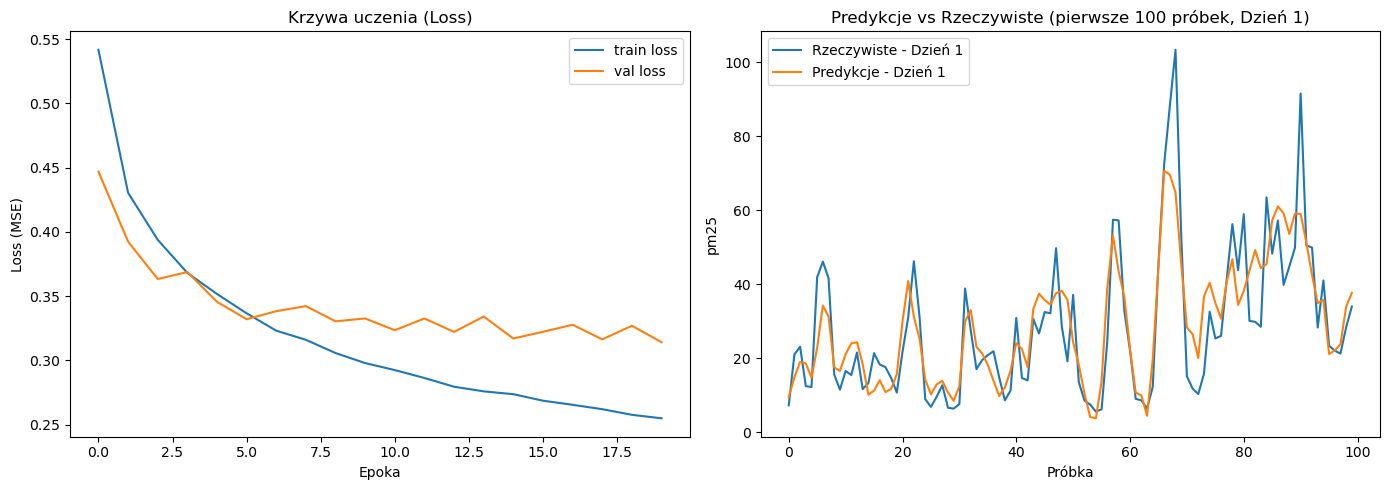

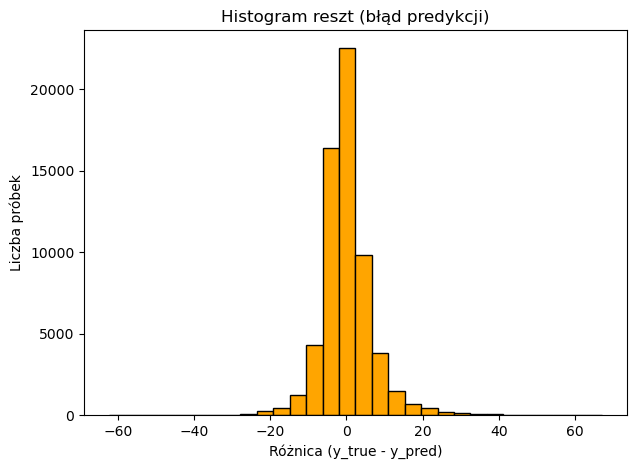

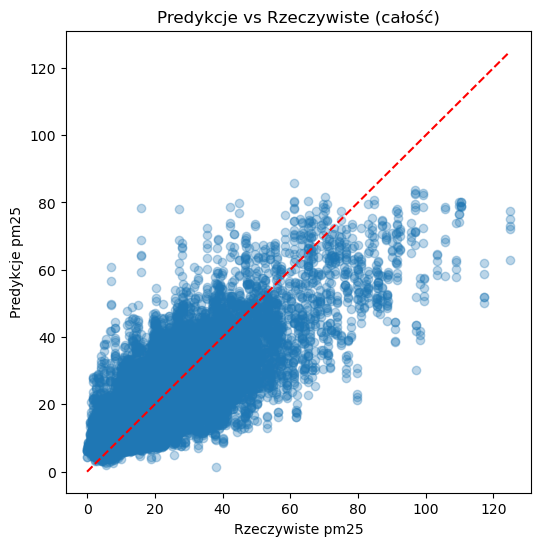

=== METRYKI GLOBALNE ===
MAE: 4.522
RMSE: 6.713
R²: 0.681
Bias: -0.058

=== METRYKI PER DZIEŃ ===

Dzień 1:
  MSE: 42.544
  RMSE: 6.523
  Bias: 0.062
  R²: 0.699
  Korelacja: 0.836


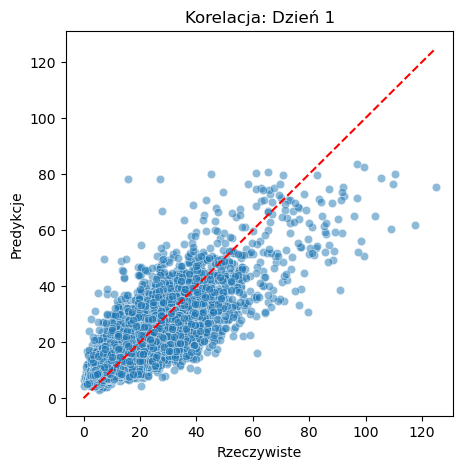


Dzień 2:
  MSE: 44.559
  RMSE: 6.675
  Bias: -0.053
  R²: 0.685
  Korelacja: 0.828


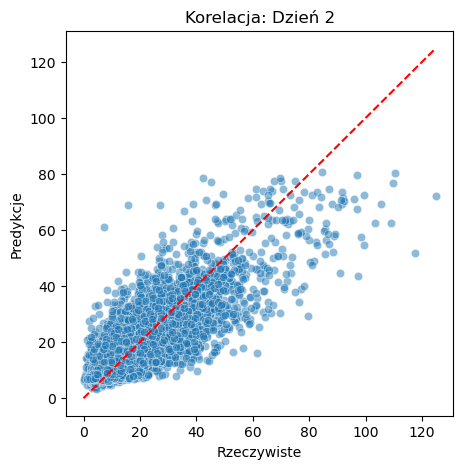


Dzień 3:
  MSE: 44.625
  RMSE: 6.680
  Bias: -0.073
  R²: 0.684
  Korelacja: 0.827


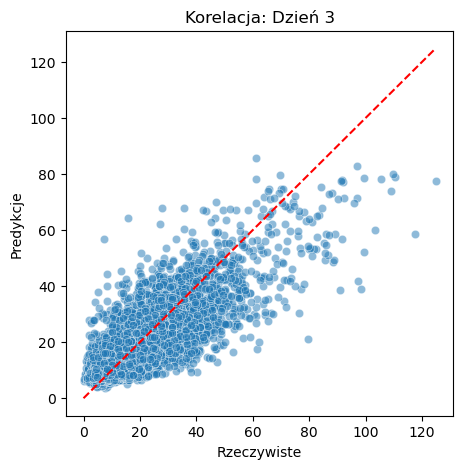


Dzień 4:
  MSE: 47.061
  RMSE: 6.860
  Bias: -0.210
  R²: 0.666
  Korelacja: 0.817


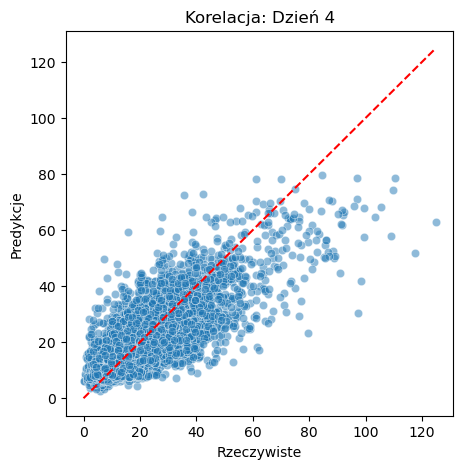


Dzień 5:
  MSE: 46.600
  RMSE: 6.826
  Bias: -0.013
  R²: 0.670
  Korelacja: 0.819


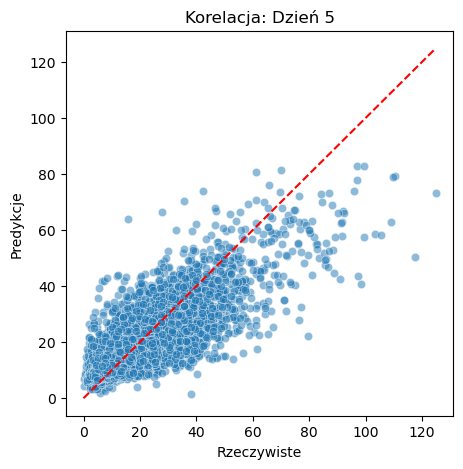

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_lstm_diagnostics_multistep(history, y_test_rescaled, y_pred_rescaled):
    """
    Rysuje diagnostykę po trenowaniu LSTM (multi-step forecast).
    
    Args:
        history: historia z model.fit()
        y_test_rescaled: macierz (n_samples, forecast_horizon)
        y_pred_rescaled: macierz (n_samples, forecast_horizon)
    """

    forecast_horizon = y_test_rescaled.shape[1]

    # 1. Krzywa uczenia
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Krzywa uczenia (Loss)')
    plt.xlabel('Epoka')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # 2. Porównanie predykcji i prawdziwych wartości dla 1. dnia
    plt.subplot(1,2,2)
    plt.plot(y_test_rescaled[:100, 0], label='Rzeczywiste - Dzień 1')
    plt.plot(y_pred_rescaled[:100, 0], label='Predykcje - Dzień 1')
    plt.title('Predykcje vs Rzeczywiste (pierwsze 100 próbek, Dzień 1)')
    plt.xlabel('Próbka')
    plt.ylabel('pm25')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Histogram reszt dla całej prognozy
    residuals = (y_test_rescaled - y_pred_rescaled).flatten()
    plt.figure(figsize=(7,5))
    plt.hist(residuals, bins=30, color='orange', edgecolor='k')
    plt.title('Histogram reszt (błąd predykcji)')
    plt.xlabel('Różnica (y_true - y_pred)')
    plt.ylabel('Liczba próbek')
    plt.show()

    # 4. Scatter plot: predykcje vs rzeczywiste dla całej prognozy
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_rescaled.flatten(), y_pred_rescaled.flatten(), alpha=0.3)
    lims = [
        min(y_test_rescaled.min(), y_pred_rescaled.min()),
        max(y_test_rescaled.max(), y_pred_rescaled.max())
    ]
    plt.plot(lims, lims, 'r--')
    plt.title('Predykcje vs Rzeczywiste (całość)')
    plt.xlabel('Rzeczywiste pm25')
    plt.ylabel('Predykcje pm25')
    plt.show()

    # 5. Metryki globalne
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    bias = np.mean(y_pred_rescaled - y_test_rescaled)

    print("=== METRYKI GLOBALNE ===")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")
    print(f"Bias: {bias:.3f}")

    # 6. Metryki i korelacje dla każdego dnia do przodu
    print("\n=== METRYKI PER DZIEŃ ===")
    for day in range(forecast_horizon):
        y_true_d = y_test_rescaled[:, day]
        y_pred_d = y_pred_rescaled[:, day]
        
        mse_d = mean_squared_error(y_true_d, y_pred_d)
        rmse_d = np.sqrt(mse_d)
        bias_d = np.mean(y_pred_d - y_true_d)
        r2_d = r2_score(y_true_d, y_pred_d)
        corr_d = np.corrcoef(y_true_d, y_pred_d)[0,1]

        print(f"\nDzień {day+1}:")
        print(f"  MSE: {mse_d:.3f}")
        print(f"  RMSE: {rmse_d:.3f}")
        print(f"  Bias: {bias_d:.3f}")
        print(f"  R²: {r2_d:.3f}")
        print(f"  Korelacja: {corr_d:.3f}")

        # Wykres korelacji
        plt.figure(figsize=(5,5))
        sns.scatterplot(x=y_true_d, y=y_pred_d, alpha=0.5)
        lims = [
            min(y_true_d.min(), y_pred_d.min()),
            max(y_true_d.max(), y_pred_d.max())
        ]
        plt.plot(lims, lims, 'r--')
        plt.xlabel('Rzeczywiste')
        plt.ylabel('Predykcje')
        plt.title(f'Korelacja: Dzień {day+1}')
        plt.show()

plot_lstm_diagnostics_multistep(history, y_test_rescaled, y_pred_rescaled)